# Num-pyro example
from https://num.pyro.ai/en/stable/examples/bnn.html

In [23]:
import torch
from torch import nn
import numpy as np
import warnings
import pyro
from pyro import distributions as dist
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO, Predictive, TraceMeanField_ELBO, JitTraceMeanField_ELBO
from pyro.optim import Adam

import matplotlib.pyplot as plt
import seaborn as sn

In [24]:
# create artificial regression dataset
def get_data(N=500, D_X=3, sigma_obs=0.05, N_test=500):
    D_Y = 1  # create 1d outputs
    np.random.seed(0)
    X = np.linspace(-1, 1, N)
    X = np.power(X[:, np.newaxis], np.arange(D_X))
    W = 0.5 * np.random.randn(D_X)
    Y = np.dot(X, W) + 0.5 * np.power(0.5 + X[:, 1], 2.0) * np.sin(4.0 * X[:, 1])
    Y += sigma_obs * np.random.randn(N)
    Y = Y[:, np.newaxis]
    Y -= np.mean(Y)
    Y /= np.std(Y)

    assert X.shape == (N, D_X)
    assert Y.shape == (N, D_Y)

    X_test = np.linspace(-1.3, 1.3, N_test)
    X_test = np.power(X_test[:, np.newaxis], np.arange(D_X))

    return X, Y, X_test

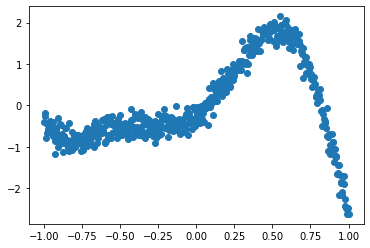

In [27]:
X, Y, X_test = get_data(D_X=2)
plt.scatter(X[:,1], Y)

In [28]:
def nonlin(x):
    return torch.tanh(x)
def model(X, Y=None, D_H=200, D_Y=1):
    N, D_X = X.shape
    
    # first layer
    w1 = pyro.sample("w1", dist.Normal(torch.zeros((D_X, D_H)), torch.ones((D_X, D_H))))
    z1 = nonlin(torch.matmul(X, w1))  # <= first layer of activations

    # second layer
    w2 = pyro.sample("w2", dist.Normal(torch.zeros((D_H, D_H)), torch.ones((D_H, D_H))))
    z2 = nonlin(torch.matmul(z1, w2))  # <= second layer of activations

    # sample final layer of weights and neural network output
    w3 = pyro.sample("w3", dist.Normal(torch.zeros((D_H, D_Y)), torch.ones((D_H, D_Y))))
    z3 = torch.matmul(z2, w3)  # <= output of the neural network

    # we put a prior on the observation noise
    prec_obs = pyro.sample("prec_obs", dist.Gamma(3.0, 1.0))
    sigma_obs = 1.0 / torch.sqrt(prec_obs)

    # observe data
    with pyro.plate("data", N):
        # note we use to_event(1) because each observation has shape (1,)
        pyro.sample("Y", dist.Normal(z3, sigma_obs).to_event(1), obs=Y)

In [29]:
pyro.clear_param_store()
# Torch data loader
data = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32))
dataloader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
guide = pyro.infer.autoguide.guides.AutoDiagonalNormal(model, init_scale=0.001 )
svi = SVI(model, guide, optimizer, loss= TraceMeanField_ELBO())

In [30]:
for step in range(2000):
    for x, y in dataloader:
        loss = svi.step(x, y, 200)
    if step % 200 == 0:
        print('[iter {}]  loss: {:.4f}'.format(step, loss))

ValueError: at site "w1", invalid log_prob shape
  Expected [], actual [2, 200]
  Try one of the following fixes:
  - enclose the batched tensor in a with pyro.plate(...): context
  - .to_event(...) the distribution being sampled
  - .permute() data dimensions

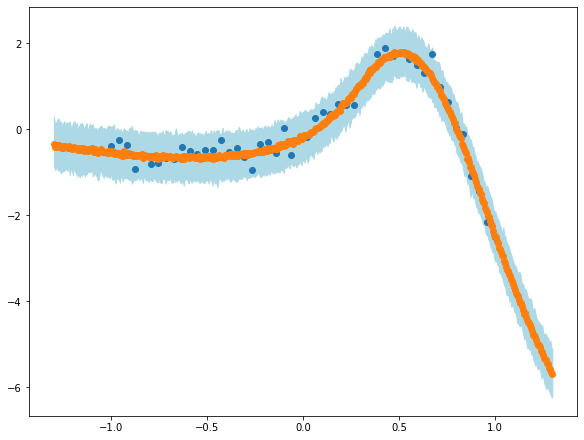

In [34]:
XT = torch.tensor(X_test, dtype=torch.float32)
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=200)(XT, None, 200)
means = np.mean(predictive["Y"].data.cpu().numpy() ,0)
percs = np.percentile(predictive["Y"].data.cpu().numpy(), [5., 95.], axis=0).squeeze()
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
ax.fill_between(X_test[:,1], percs[0,:], percs[1,:], color="lightblue")
ax.scatter(X[:,1], Y)
ax.scatter(X_test[:,1], means)



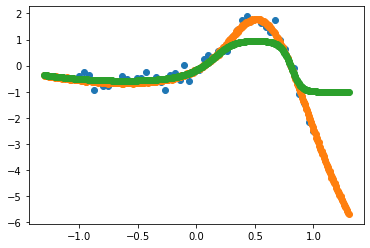

In [35]:
plt.scatter(X[:,1], Y)
plt.scatter(X_test[:,1], means)
plt.scatter(X_test[:,1], nonlin(nonlin(nonlin( XT.matmul(guide.median()["w1"]) ).matmul( guide.median()["w2"] )).matmul(guide.median()["w3"] )).data.cpu().numpy() )


In [32]:
pyro.clear_param_store()
mcmc = MCMC( pyro.infer.NUTS(model), num_samples=100)
mcmc.run(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32), 10)

Warmup:  12%|█▎        | 25/200 [00:16,  1.44s/it, step size=2.30e-03, acc. prob=0.751]

KeyboardInterrupt: 

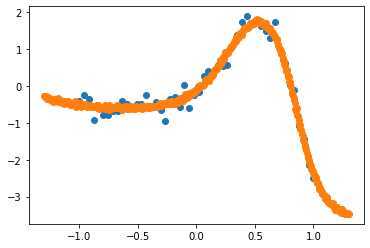

In [110]:
predictive = Predictive(model, mcmc.get_samples())(XT, None)
means = np.mean(predictive["Y"].data.cpu().numpy() ,0)
percs = np.percentile(predictive["Y"].data.cpu().numpy(), [5., 95.], axis=0)
plt.scatter(X[:,1], Y)
plt.scatter(X_test[:,1], means)
